Matplotlib is building the font cache; this may take a moment.


Shape: (569, 31)
Classes distribution:
 target
1    357
0    212
Name: count, dtype: int64
Any missing values? 0
                 count        mean         std        min        25%  \
mean radius      569.0   14.127292    3.524049    6.98100   11.70000   
mean texture     569.0   19.289649    4.301036    9.71000   16.17000   
mean perimeter   569.0   91.969033   24.298981   43.79000   75.17000   
mean area        569.0  654.889104  351.914129  143.50000  420.30000   
mean smoothness  569.0    0.096360    0.014064    0.05263    0.08637   

                       50%       75%        max  
mean radius       13.37000   15.7800    28.1100  
mean texture      18.84000   21.8000    39.2800  
mean perimeter    86.24000  104.1000   188.5000  
mean area        551.10000  782.7000  2501.0000  
mean smoothness    0.09587    0.1053     0.1634  


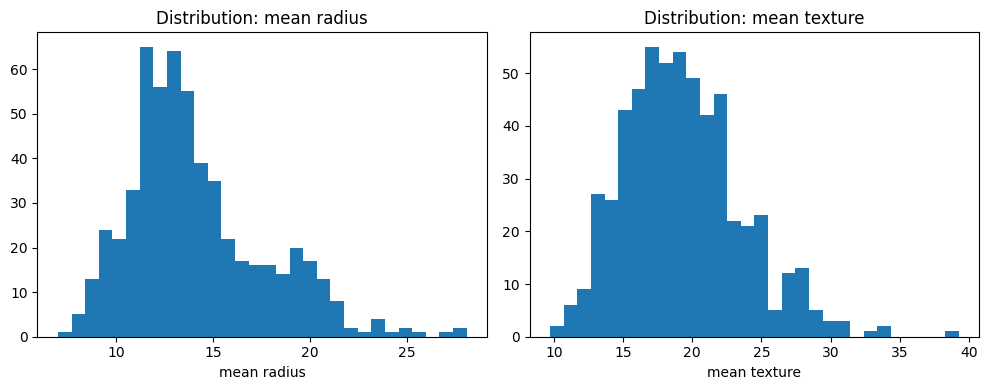

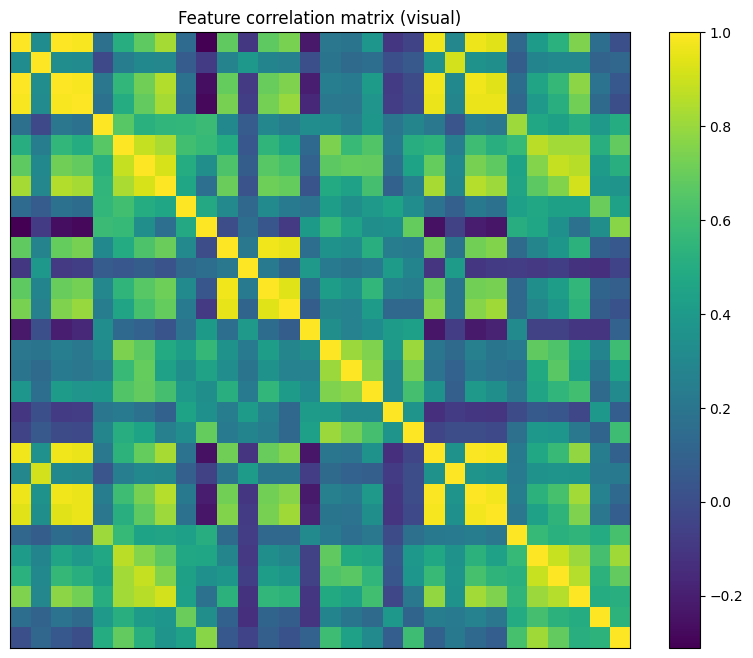

Features kept after VarianceThreshold: 30

Top features by SelectKBest (k=10):
 ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']

Top features by RFE (n=10):
 ['mean radius', 'mean concavity', 'mean concave points', 'mean symmetry', 'worst radius', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Train shape (all features): (455, 30)
Train shape (selected features): (455, 10)
LogisticRegression CV accuracy: 0.9802 (+/- 0.0128)
RandomForest CV accuracy: 0.9538 (+/- 0.0235)
GradientBoosting CV accuracy: 0.9582 (+/- 0.0108)
Best RF params: {'clf__max_depth': 5, 'clf__n_estimators': 50}
Best RF CV score: 0.9516483516483516
Test accuracy: 0.9298245614035088
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1    

In [1]:
# Predictive Analysis using Machine Learning
# Breast Cancer (Wisconsin) — Classification
# Student-style notebook

# ======================
# 1) Imports
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)


# ======================
# 2) Load dataset
# ======================
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign

df = pd.concat([X, y], axis=1)

print("Shape:", df.shape)
print("Classes distribution:\n", df['target'].value_counts())
print("Any missing values?", df.isnull().sum().sum())

print(df.describe().T.head())

# ======================
# 3) Visualization
# ======================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['mean radius'], bins=30)
plt.title('Distribution: mean radius')
plt.xlabel('mean radius')

plt.subplot(1,2,2)
plt.hist(df['mean texture'], bins=30)
plt.title('Distribution: mean texture')
plt.xlabel('mean texture')
plt.tight_layout()

plt.figure(figsize=(10,8))
corr = X.corr()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title('Feature correlation matrix (visual)')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

# ======================
# 4) Feature Selection
# ======================
# 4.1 Variance Threshold
vt = VarianceThreshold(threshold=0.0)
vt.fit(X)
cols_nonzero = X.columns[vt.get_support()]
print('Features kept after VarianceThreshold:', len(cols_nonzero))

# 4.2 SelectKBest
k = 10
sk = SelectKBest(score_func=f_classif, k=k)
sk.fit(X, y)
cols_kbest = X.columns[sk.get_support()]   # FIXED (was "s k")

# 4.3 RFE (Recursive Feature Elimination)
lr = LogisticRegression(max_iter=5000, solver='liblinear', random_state=42)
rfe = RFE(estimator=lr, n_features_to_select=10)
rfe.fit(X, y)
cols_rfe = X.columns[rfe.get_support()]

print('\nTop features by SelectKBest (k=%d):\n' % k, list(cols_kbest))
print('\nTop features by RFE (n=10):\n', list(cols_rfe))

# ======================
# 5) Train/Test Split
# ======================
X_all = X.copy()
X_sel = X[cols_rfe].copy()

X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)
X_train_sel, X_test_sel, _, _ = train_test_split(
    X_sel, y, test_size=0.2, stratify=y, random_state=42
)

print('Train shape (all features):', X_train_all.shape)
print('Train shape (selected features):', X_train_sel.shape)

# ======================
# 6) Model Pipelines
# ======================
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=5000, solver='liblinear', random_state=42))
])
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))
])

models = {
    'LogisticRegression': pipe_lr,
    'RandomForest': pipe_rf,
    'GradientBoosting': pipe_gb
}

# ======================
# 7) Cross-validation
# ======================
for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X_train_all, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# ======================
# 8) Hyperparameter Tuning
# ======================
param_grid_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5, 10]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_train_sel, y_train)
print('Best RF params:', gs_rf.best_params_)
print('Best RF CV score:', gs_rf.best_score_)

# ======================
# 9) Evaluation
# ======================
best_rf = gs_rf.best_estimator_
y_pred = best_rf.predict(X_test_sel)

print('Test accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# ROC AUC
y_prob = best_rf.predict_proba(X_test_sel)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
print('Test ROC AUC:', roc_auc)

# ======================
# 10) Feature Importance
# ======================
feat_importances = best_rf.named_steps['clf'].feature_importances_
feat_df = pd.DataFrame({
    'feature': X_sel.columns,
    'importance': feat_importances
}).sort_values('importance', ascending=False)
print(feat_df.head(10))

# ======================
# 11) Save Model
# ======================
print('Saved model to best_rf_model.pkl')
